# MLP

This is an MLP model that explores using a single vector derived from pre-trained word embedding vectors.


Step 1: Importing the required libraries

In [219]:
import numpy as np
import pandas as pd
import re
import nltk

import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import regularizers
from keras.optimizers import Adam

Step 2: Loading the pre-trained glove vector embedding model 

In [134]:
# Load pre-trained embedding layer
filename = "C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\glove.6B.300d.txt.word2vec"
glove = KeyedVectors.load_word2vec_format(filename, binary=False) # for now binary is true

Step 3: Load training and testing data

In [209]:
# Load the training dataset
df_training = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\train.csv', delimiter=',')
X_train = df_training.values[:,0]
y_train = np.array(df_training.values[:, 1], dtype=np.float32)

# Load the testing 
df_testing = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\test.csv')  
X_test = np.array(df_testing.values[:,0])
y_test = np.array(df_testing.values[:,1], dtype=np.float32)

Step 4: Pre-Processing training and testing data:

This phase creates a new csv file with pre-processed data that can be used by each of the models it has a few functions including: 

- Remove any punctuation
- make sentences lowercase
- Remove URL's
- Lemize words
- Tokenise the words
- Remove stop words



In [210]:
# Preprocess the text: lowercase, remove special characters, tokenize
def remove_special_characters_and_tokenise(text):
    # Lower case the text
    text = text.lower()
    # Remove special characters
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = []
    for word in nltk.word_tokenize(text):
        tokens.extend(re.findall(r'\b\w+\b', word))  # Split combined words into separate tokens
    return tokens

# Remove stopwords
def remove_stopwords(tokens):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    return [word for word in tokens if word not in stopwords]

# Lemmatization
def perform_lemmatization(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# Clean the sentence: Apply the cleaning process to a single sentence
def clean_sentence(sentence):
    tokens = remove_special_characters_and_tokenise(sentence)
    tokens = remove_stopwords(tokens)
    tokens = perform_lemmatization(tokens)
    return tokens

# Preprocess the data: Apply the cleaning process to all sentences in data
def pre_process_data(data):
    token_arrays = []  
    for sentence in data:
        tokens = clean_sentence(sentence)
        token_arrays.append(np.array(tokens))

    return [' '.join(tokens) for tokens in token_arrays]

In [211]:
X_train = pre_process_data(X_train)
X_test = pre_process_data(X_test)

Tokenise the keras words

In [212]:
# Create a tokenizer to convert words to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [213]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences as keras_pad_sequences

def my_pad_sequences(data, max_len): 
    padded_data = keras_pad_sequences(data, maxlen=max_len, padding='post', dtype='float32')
    return np.array(padded_data)

In [214]:
max_len = max([len(sentence) for sentence in X_train])
X_train = my_pad_sequences(X_train, max_len)
X_test = my_pad_sequences(X_test, max_len)

Create token embeddings for each of the pre-processed words using pre-trained word vectors glove

In [215]:
def embed_text_glove(token_sequences, word_index):
    embedded_text = []
    for sequence in token_sequences:
        embedded_sentence = []
        for word_idx in sequence:  # Rename the loop variable to word_idx
            try:
                if (word_idx == 0):
                    embedded_sentence.append(np.zeros(300))
                    continue
                word = next(word for word, index in word_index.items() if index == word_idx)  # Rename word_index to word_idx
                embedded_word = glove[word]
                embedded_sentence.append(embedded_word)
            except KeyError:
                embedded_sentence.append(np.zeros(300))
        embedded_text.append(embedded_sentence)
    return np.array(embedded_text)

In [216]:
X_train_glove_embedded = embed_text_glove(X_train, word_index) 
X_test_glove_embedded = embed_text_glove(X_test, word_index)

Create a function which creates the model

In [218]:
# flatten the embeddings vector represenetaiton
flattend_training_data = X_train_glove_embedded.reshape(X_train_glove_embedded.shape[0], -1)

# Define the MLP model
model = Sequential()
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.01), input_shape=(flattend_training_data.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
learning_rate = 0.05
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
training_labels = np.array(y_train, dtype=np.float32)

# Train the model
model.fit(flattend_training_data, training_labels, epochs=20, batch_size=50, validation_split=0.2)

c:\Users\ryanm\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5887 - loss: 811.4490 - val_accuracy: 0.7100 - val_loss: 507.8629
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7241 - loss: 395.6729 - val_accuracy: 0.7550 - val_loss: 300.5889
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7272 - loss: 266.0394 - val_accuracy: 0.7325 - val_loss: 180.5785
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6773 - loss: 223.4705 - val_accuracy: 0.7700 - val_loss: 208.6257
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6893 - loss: 218.8656 - val_accuracy: 0.7825 - val_loss: 220.7472
Epoch 6/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6828 - loss: 223.8527 - val_accuracy: 0.7900 - val_loss: 228.0855
Epoch 7/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6872 - loss: 219.2044 - val_accuracy: 0.7300 - val_loss: 238.7019
Epoch 8/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7098 - los

KeyboardInterrupt: 

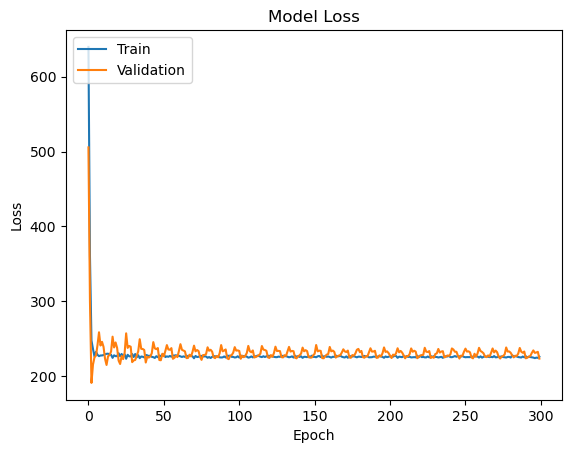

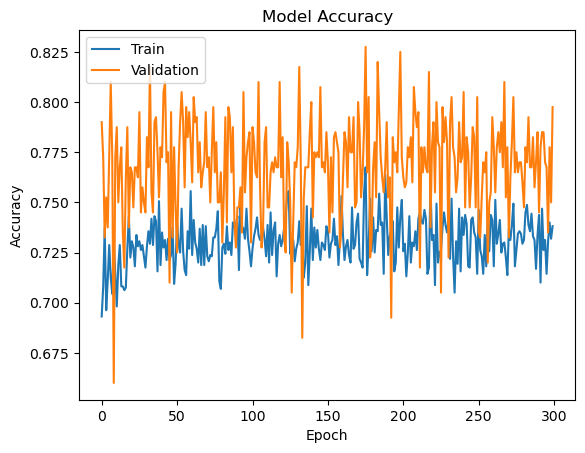

In [206]:
# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


loss = model.evaluate(, y_training)
print("Loss:", loss)


In [207]:
X_test_glove_embedded = X_test_glove_embedded.reshape(X_test_glove_embedded.shape[0], -1)
testing_labels = np.array(y_test, dtype=np.float32)
loss, accuracy = model.evaluate(X_test_glove_embedded, testing_labels)
print("Loss:", loss)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8009 - loss: 223.6277
Loss: 223.62796020507812


Using test data to see model performance: This validation and training perfromacne proves that there is overfitting in the model. It seems after experimenation that a standard MLP is not fit for the task of determining false information or true information. I tried changing model hyper parameters such as batch size, and learning rate as well as changing model archetecture as I believe that the model was not performing well due to being to complex but perhaps I was wrong.

Now I will try the model using the keras embedding layer instead of just flattening the text embeddings. 

In [135]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer


# Convert text data to sequences of word indices

tokenizer = Tokenizer()

tokenizer.fit_on_texts(training_data)

word_indices = tokenizer.fit_on_texts(training_data)
word_indices = tokenizer.texts_to_sequences(training_data)

# Pad sequences to ensure uniform length
max_sequence_length = 100  # Adjust as needed
padded_sequences = pad_sequences(word_indices, maxlen=max_sequence_length)

# Define the MLP model
model = Sequential()
model.add(Embedding(input_dim=len(word_indices), output_dim=word, input_length=max_sequence_length))
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_regularizer='l1'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer='l1'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
learning_rate = 0.05
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Convert training labels to numpy array
training_labels = np.array(training_labels, dtype=np.float32)

# Train the model
model.fit(padded_sequences, training_labels, epochs=100, batch_size=200, validation_split=0.2)

[69, 189, 223, 3470, 7, 213, 3471, 59, 855, 326, 1033, 432, 3472, 59, 541, 462, 1631, 1272, 5, 20]
